<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Ana Sofia Dürrmüller Acosta y Jose Alberto Mayagoitia Gutierrez

**Fecha:** 25 de Noviembre 

**Expediente** : if723489 y if720266

**Profesor:** Oscar David Jaramillo Zuluaga.

**Link Github:** https://github.com/anadurrmuller/Tarea9-10_ASDurrmuller_JAMayagoitia.git

# Tarea 9

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla: 

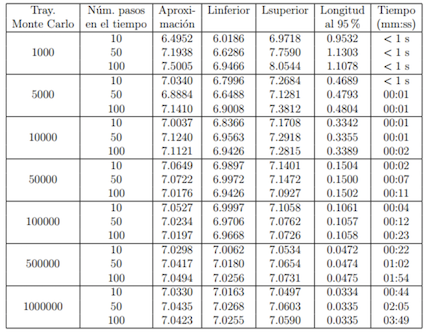

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método.

Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
Compare los resultados obtenidos con los resultados arrojados por la función Riemann_approach. Concluya. **(30 puntos)**

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import time
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
# Solucion estudiante 1. Ana Sofia

In [3]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

In [4]:
# Función donde se almacenan todos los resultados
def Metodo_trapecio_Call(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                     flag=None):
    start = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Definimos el dataframe de strikes
    strike = K
    # h = T/N
    h = T/NbStep
    # w
    w_s = np.random.randn(NbStep, NbTraj)
    # Obtenemos los precios promedios
    sum_st = np.cumsum(prices * (2 + r*h + w_s * sigma))
    Average_t = (h/(2*T)) * sum_st
    
    # Calculamos el call de la opción según la formula de trapecios
    call = pd.DataFrame({'Prima': np.exp(-r*T) \
                 *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    long95 = i1[1] - i1[0]
    end = time.time()
    tiempo = int(end - start)
    tiempo2 = '{:02d}:{:02d}'.format((tiempo % 3600 //60), tiempo % 60)
    segundos = lambda x: '<1 s' if x == '00:00' else x
    return np.array([np.round(call.iloc[-1].Prima, 4), np.round(i1[0], 4), np.round(i1[1],4), np.round(long95,4), 
             segundos(tiempo2)])

In [5]:
# Función donde se almacenan todos los resultados
def Metodo_trapecio_Put(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                     flag=None):
    start = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Definimos el dataframe de strikes
    strike = K
    # h = T/N
    h = T/NbStep
    # w
    w_s = np.random.randn(NbStep, NbTraj)
    # Obtenemos los precios promedios
    sum_st = np.cumsum(prices * (2 + r*h + w_s * sigma))
    Average_t = (h/(2*T)) * sum_st
    
    # Calculamos el call de la opción según la formula de trapecios
    put = pd.DataFrame({'Prima': np.exp(-r*T) \
                 *np.fmax(strike - Average_t, 0).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put.sem().Prima
    mean_est = put.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    long95 = i1[1] - i1[0]
    end = time.time()
    tiempo = int(end - start)
    tiempo2 = '{:02d}:{:02d}'.format((tiempo % 3600 //60), tiempo % 60)
    segundos = lambda x: '<1 s' if x == '00:00' else x
    return np.array([np.round(put.iloc[-1].Prima, 4), np.round(i1[0], 4), np.round(i1[1],4), np.round(long95, 4), 
             segundos(tiempo2)])

In [6]:
# DATOS
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
NbStep = [10, 50, 100]
S0 = 100
K = 100
r = 0.10
sigma = 0.20
T = 1

In [7]:
opt_call = np.array(list(map(lambda N_traj: list(map(lambda N_step:  Metodo_trapecio_Call(K, r, S0, N_traj, N_step, sigma, T), 
                                           NbStep)),NbTraj)))
opt_put = np.array(list(map(lambda N_traj: list(map(lambda N_step:  Metodo_trapecio_Put(K, r, S0, N_traj, N_step, sigma, T), 
                                           NbStep)),NbTraj)))

### CALL

In [8]:
# Indice trayectorias
indice_t = [i for i in NbTraj for _ in (0,1,2)]
# resultados de cada serie de pasos
resultados = np.array(list(map(lambda i: opt_call[:,:,i].flatten(), range(5)))) 
# Indice pasos
indice_p = [indice_t, NbStep*(len(NbTraj)), resultados[0], resultados[1], resultados[2], resultados[3], resultados[4]]
# MultiIndex
Multi_Index = pd.MultiIndex.from_arrays(indice_p, names = ('Tray. Monte Carlo', 'Núm. pasos en el tiempo', 'Aproximación',
                                 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo (mm:ss)'))
tabla_call_t = pd.DataFrame(index = Multi_Index)
tabla_call_t

Empty DataFrame
Columns: []
Index: [(1000, 10, 6.783, 5.4509, 8.1152, 2.6643, <1 s), (1000, 50, 6.8722, 6.4716, 7.2727, 0.801, <1 s), (1000, 100, 7.0539, 6.7767, 7.3311, 0.5543, <1 s), (5000, 10, 6.8551, 5.5109, 8.1993, 2.6884, <1 s), (5000, 50, 7.1094, 6.6891, 7.5297, 0.8406, <1 s), (5000, 100, 7.0286, 6.7523, 7.3049, 0.5526, <1 s), (10000, 10, 7.0283, 5.6488, 8.4078, 2.759, <1 s), (10000, 50, 7.0561, 6.6393, 7.473, 0.8337, <1 s), (10000, 100, 7.1032, 6.8235, 7.3828, 0.5593, <1 s), (50000, 10, 6.9093, 5.5541, 8.2645, 2.7104, <1 s), (50000, 50, 6.9815, 6.5698, 7.3933, 0.8235, <1 s), (50000, 100, 6.9693, 6.696, 7.2426, 0.5466, <1 s), (100000, 10, 6.8941, 5.5419, 8.2464, 2.7044, <1 s), (100000, 50, 7.0273, 6.6119, 7.4427, 0.8309, <1 s), (100000, 100, 7.0421, 6.7654, 7.3187, 0.5533, 00:01), (500000, 10, 6.8967, 5.5441, 8.2493, 2.7052, 00:01), (500000, 50, 6.9972, 6.5842, 7.4101, 0.8259, 00:03), (500000, 100, 7.0044, 6.729, 7.2798, 0.5507, 00:06), (1000000, 10, 6.9244, 5.5663, 8.2825, 2.7163, 00:02), (1000000, 50, 7.0136, 6.5994, 7.4278, 0.8283, 00:07), (1000000, 100, 7.0206, 6.7445, 7.2967, 0.5522, 00:15)]

### PUT

In [9]:
# Indice trayectorias
indice_t = [i for i in NbTraj for _ in (0,1,2)]
# resultados de cada serie de pasos
resultados = np.array(list(map(lambda i: opt_put[:,:,i].flatten(), range(5)))) 
# Indice pasos
indice_p = [indice_t, NbStep*(len(NbTraj)), resultados[0], resultados[1], resultados[2], resultados[3], resultados[4]]
# MultiIndex
Multi_Index = pd.MultiIndex.from_arrays(indice_p, names = ('Tray. Monte Carlo', 'Núm. pasos en el tiempo', 'Aproximación',
                                 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo (mm:ss)'))
tabla_put_t = pd.DataFrame(index = Multi_Index)
tabla_put_t

Empty DataFrame
Columns: []
Index: [(1000, 10, 2.0805, -15.0678, 19.2287, 34.2965, <1 s), (1000, 50, 2.4747, -4.9501, 9.8995, 14.8496, <1 s), (1000, 100, 2.0518, -3.227, 7.3305, 10.5575, <1 s), (5000, 10, 2.2541, -14.8589, 19.3672, 34.226, <1 s), (5000, 50, 2.2725, -5.1959, 9.7408, 14.9367, <1 s), (5000, 100, 2.3183, -2.9415, 7.5782, 10.5197, <1 s), (10000, 10, 2.2626, -14.8477, 19.373, 34.2207, <1 s), (10000, 50, 2.3657, -5.0947, 9.8262, 14.9209, <1 s), (10000, 100, 2.3613, -2.8962, 7.6188, 10.5149, <1 s), (50000, 10, 2.2017, -14.92, 19.3233, 34.2433, <1 s), (50000, 50, 2.3335, -5.127, 9.794, 14.921, <1 s), (50000, 100, 2.3167, -2.9432, 7.5767, 10.5199, <1 s), (100000, 10, 2.227, -14.8883, 19.3422, 34.2305, <1 s), (100000, 50, 2.3148, -5.1499, 9.7794, 14.9293, <1 s), (100000, 100, 2.3397, -2.919, 7.5984, 10.5173, 00:01), (500000, 10, 2.2199, -14.8988, 19.3385, 34.2373, 00:01), (500000, 50, 2.3357, -5.1254, 9.7969, 14.9222, 00:03), (500000, 100, 2.3497, -2.9081, 7.6075, 10.5156, 00:06), (1000000, 10, 2.2187, -14.9012, 19.3387, 34.2399, 00:02), (1000000, 50, 2.3339, -5.1282, 9.7961, 14.9243, 00:06), (1000000, 100, 2.348, -2.9096, 7.6055, 10.515, 00:11)]

In [10]:
#Con Riemmann_approach

# Función donde se almacenan todos los resultados
def Riemann_approach_call(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    start = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima': np.exp(-r*T) \
                 *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    long95 = i1[1] - i1[0]
    end = time.time()
    tiempo = int(end - start)
    tiempo2 = '{:02d}:{:02d}'.format((tiempo % 3600 //60), tiempo % 60)
    segundos = lambda x: '<1 s' if x == '00:00' else x
    return np.array([np.round(call.iloc[-1].Prima, 4), np.round(i1[0], 4), np.round(i1[1],4), np.round(long95,4), 
             segundos(tiempo2)])

In [11]:
# Función donde se almacenan todos los resultados
def Riemann_approach_put(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    start = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    put = pd.DataFrame({'Prima': np.exp(-r*T) \
                 *np.fmax(strike - Average_t, 0).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put.sem().Prima
    mean_est = put.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    long95 = i1[1] - i1[0]
    end = time.time()
    tiempo = int(end - start)
    tiempo2 = '{:02d}:{:02d}'.format((tiempo % 3600 //60), tiempo % 60)
    segundos = lambda x: '<1 s' if x == '00:00' else x
    return np.array([np.round(put.iloc[-1].Prima, 4), np.round(i1[0], 4), np.round(i1[1],4), np.round(long95,4), 
             segundos(tiempo2)])

In [12]:
# DATOS
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
NbStep = [10, 50, 100]
S0 = 100
K = 100
r = 0.10
sigma = 0.20
T = 1

In [13]:
opt_call_sr = np.array(list(map(lambda N_traj: list(map(lambda N_step:  Riemann_approach_call(K, r, S0, N_traj, N_step, sigma, T), 
                                           NbStep)),NbTraj)))
opt_put_sr = np.array(list(map(lambda N_traj: list(map(lambda N_step:  Riemann_approach_put(K, r, S0, N_traj, N_step, sigma, T), 
                                           NbStep)),NbTraj)))

### CALL

In [14]:
# Indice trayectorias
indice_t = [i for i in NbTraj for _ in (0,1,2)]
# resultados de cada serie de pasos
resultados = np.array(list(map(lambda i: opt_call_sr[:,:,i].flatten(), range(5)))) 
# Indice pasos
indice_p = [indice_t, NbStep*(len(NbTraj)), resultados[0], resultados[1], resultados[2], resultados[3], resultados[4]]
# MultiIndex
Multi_Index = pd.MultiIndex.from_arrays(indice_p, names = ('Tray. Monte Carlo', 'Núm. pasos en el tiempo', 'Aproximación',
                                 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo (mm:ss)'))
tabla_call_sr = pd.DataFrame(index = Multi_Index)
tabla_call_sr

Empty DataFrame
Columns: []
Index: [(1000, 10, 5.9974, 4.8124, 7.1824, 2.3701, <1 s), (1000, 50, 6.7226, 6.2271, 7.2182, 0.9911, <1 s), (1000, 100, 7.0771, 6.7118, 7.4424, 0.7306, <1 s), (5000, 10, 6.3247, 5.0733, 7.5762, 2.503, <1 s), (5000, 50, 7.0689, 6.5385, 7.5992, 1.0607, <1 s), (5000, 100, 6.9827, 6.6212, 7.3442, 0.7229, <1 s), (10000, 10, 6.4042, 5.1317, 7.6767, 2.545, <1 s), (10000, 50, 6.885, 6.3716, 7.3983, 1.0267, <1 s), (10000, 100, 6.9873, 6.6287, 7.346, 0.7174, <1 s), (50000, 10, 6.3751, 5.112, 7.6382, 2.5262, <1 s), (50000, 50, 6.941, 6.4223, 7.4598, 1.0375, <1 s), (50000, 100, 6.9481, 6.5902, 7.3061, 0.7159, 00:01), (100000, 10, 6.467, 5.1841, 7.7499, 2.5659, 00:01), (100000, 50, 6.9422, 6.4247, 7.4597, 1.0349, 00:01), (100000, 100, 6.9787, 6.6188, 7.3386, 0.7198, 00:02), (500000, 10, 6.4348, 5.1589, 7.7107, 2.5518, 00:07), (500000, 50, 6.9167, 6.4008, 7.4325, 1.0317, 00:08), (500000, 100, 6.9739, 6.6145, 7.3333, 0.7188, 00:10), (1000000, 10, 6.4148, 5.1433, 7.6862, 2.5429, 00:14), (1000000, 50, 6.9217, 6.405, 7.4383, 1.0333, 00:17), (1000000, 100, 6.9734, 6.6142, 7.3327, 0.7185, 00:21)]

### PUT

In [15]:
# Indice trayectorias
indice_t = [i for i in NbTraj for _ in (0,1,2)]
# resultados de cada serie de pasos
resultados = np.array(list(map(lambda i: opt_put_sr[:,:,i].flatten(), range(5)))) 
# Indice pasos
indice_p = [indice_t, NbStep*(len(NbTraj)), resultados[0], resultados[1], resultados[2], resultados[3], resultados[4]]
# MultiIndex
Multi_Index = pd.MultiIndex.from_arrays(indice_p, names = ('Tray. Monte Carlo', 'Núm. pasos en el tiempo', 'Aproximación',
                                 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo (mm:ss)'))
tabla_put_sr = pd.DataFrame(index = Multi_Index)
tabla_put_sr

Empty DataFrame
Columns: []
Index: [(1000, 10, 2.1956, 1.7692, 2.6219, 0.8526, <1 s), (1000, 50, 2.4489, 2.2934, 2.6043, 0.3109, <1 s), (1000, 100, 2.4732, 2.3595, 2.5868, 0.2273, <1 s), (5000, 10, 2.2303, 1.8068, 2.6537, 0.847, <1 s), (5000, 50, 2.4059, 2.2532, 2.5586, 0.3054, <1 s), (5000, 100, 2.2951, 2.1991, 2.3911, 0.192, <1 s), (10000, 10, 2.1912, 1.7697, 2.6128, 0.8432, <1 s), (10000, 50, 2.3216, 2.1751, 2.468, 0.2929, <1 s), (10000, 100, 2.2737, 2.178, 2.3693, 0.1913, <1 s), (50000, 10, 2.2485, 1.8179, 2.6792, 0.8613, <1 s), (50000, 50, 2.3399, 2.1913, 2.4886, 0.2974, <1 s), (50000, 100, 2.3305, 2.2318, 2.4292, 0.1974, 00:01), (100000, 10, 2.2097, 1.7866, 2.6328, 0.8462, 00:01), (100000, 50, 2.3454, 2.1964, 2.4944, 0.298, 00:01), (100000, 100, 2.3602, 2.2595, 2.4608, 0.2013, 00:02), (500000, 10, 2.2281, 1.801, 2.6552, 0.8542, 00:07), (500000, 50, 2.338, 2.1896, 2.4865, 0.2969, 00:08), (500000, 100, 2.3361, 2.2369, 2.4352, 0.1983, 00:10), (1000000, 10, 2.2182, 1.7929, 2.6436, 0.8507, 00:14), (1000000, 50, 2.3357, 2.1876, 2.4839, 0.2963, 00:17), (1000000, 100, 2.3457, 2.2459, 2.4455, 0.1996, 00:21)]

**Conclusion:**
- Comparación CALL

Se dio una mejor aproximación al valor real de la prima en el primer codigo, se acerca a un valor bastante cercano y despues unicamente varía en pequeña proporción.
Por otro lado, el método de sumas de Riemann, podemos ver que en general los intervalos de confianza son mayores, además de que los valores aproximados presentan una mayor variación unos de otros baja.

- Comparación PUT

Podemos ver por ambos métodos que el valor de la prima de la opción put, con los dos se logra hacer una muy buena aproximación.

In [16]:
# Solucion estudiante 2. Jose Alberto

### Función Riemann_approach Call and Put

In [17]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from time import time
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [18]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

In [19]:
def Riemann_approach_call(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    # Resolvemos la ecuación de black scholes para obtener los precios
    t1 = time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(Average_t-strike,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t_1 = time()
    t_2 = t_1-t1
    return call.iloc[-1].Prima,i1[0],i1[1],i1[1]-i1[0],t_2

In [20]:
def Riemann_approach_put(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    # Resolvemos la ecuación de black scholes para obtener los precios
    t2 = time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    put = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(strike-Average_t,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put.sem().Prima
    mean_est = put.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t_1 = time()
    t_2 = t_1-t2
    return put.iloc[-1].Prima,i1[0],i1[1],i1[1]-i1[0],t_2

In [21]:
S0 = 100    
r = 0.10     
sigma = 0.2  
K = 100      
T = 1  
NbTraj = [1000,5000,10000,50000,100000,500000,1000000] 
NbStep = [10,50,100]   

In [22]:
call_Riem = list(map(lambda N_1:list(map(lambda N1:Riemann_approach_call(K,r,S0,N1,N_1,sigma,T),NbStep)),NbTraj))

put_Riem = list(map(lambda N_2:list(map(lambda N2:Riemann_approach_put(K,r,S0,N2,N_2,sigma,T),NbStep)), NbTraj))

In [23]:
# Visualización de datos 
filas = ['Nbtray = %i' %i for i in NbTraj]
col = ['NbStep = %i' %i for i in NbStep]
df = pd.DataFrame(index=filas,columns=col)
df.loc[:,:] = call_Riem
df

NbStep = 10  \
Nbtray = 1000     (3.2068781001652167, 3.1662489541513317, 3.247...   
Nbtray = 5000     (4.885204995792559, 4.852674429017739, 4.91773...   
Nbtray = 10000    (8.460471549728911, 8.414600127132859, 8.50634...   
Nbtray = 50000    (9.021683013617569, 8.998132965888706, 9.04523...   
Nbtray = 100000   (8.64687156417353, 8.632814829381697, 8.660928...   
Nbtray = 500000   (5.562965501101279, 5.55874835540096, 5.567182...   
Nbtray = 1000000  (5.8914545132285525, 5.888392879934945, 5.8945...   

                                                        NbStep = 50  \
Nbtray = 1000     (6.506777434898339, 6.4106954456542535, 6.6028...   
Nbtray = 5000     (4.882158414969073, 4.851340273412081, 4.91297...   
Nbtray = 10000    (9.300186524281413, 9.253482926221048, 9.34689...   
Nbtray = 50000    (7.1384727668250845, 7.12123197262743, 7.15571...   
Nbtray = 100000   (7.518559920859887, 7.506326764013397, 7.53079...   
Nbtray = 500000   (7.675780897229271, 7.670242825988936, 7.68131...   
Nbtray = 1000000  (7.074090084805286, 7.0700808579391206, 7.0780...   

                                                       NbStep = 100  
Nbtray = 1000     (7.632009908952918, 7.507680292032399, 7.75633...  
Nbtray = 5000     (6.925375003895025, 6.8739856245373545, 6.9767...  
Nbtray = 10000    (7.702355576126498, 7.661155549457069, 7.74355...  
Nbtray = 50000    (7.053585657789509, 7.039294663931725, 7.06787...  
Nbtray = 100000   (4.518006809309302, 4.510898257762881, 4.52511...  
Nbtray = 500000   (6.746747440179397, 6.742197430956843, 6.75129...  
Nbtray = 1000000  (6.300112277015956, 6.297052991763946, 6.30317...

In [24]:
Aprox = [call_Riem[i][j][0] for i in range(7) for j in range(3)]
Linferior = [call_Riem[i][j][1] for i in range(7) for j in range(3)]
Lsuperior = [call_Riem[i][j][2] for i in range(7) for j in range(3)]
Longitud95 = [call_Riem[i][j][3] for i in range(7) for j in range(3)]
Tiempo = [call_Riem[i][j][4] for i in range(7) for j in range(3)]

In [25]:
steps = [10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100]
Trayectories = [1000,1000,1000,5000,5000,5000,10000,10000,10000,50000,50000,50000,100000,
                100000,100000,500000,500000,500000,1000000,1000000,1000000]

Rcall = pd.DataFrame({'Aproximacion':Aprox ,
                          'Linferior':Linferior,
                          'Lsuperior':Lsuperior,
                          'Longitud al 95%':Longitud95,
                          'Tiempo mm:ss':Tiempo})

Rcall['Tray. Monte Carlo'] = Trayectories 
Rcall['Núm. pasos en el tiempo']=steps
Rcall.set_index(['Tray. Monte Carlo','Núm. pasos en el tiempo'],inplace=True)
Rcall.sort_index(inplace=True)

Rcall

Aproximacion  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              3.207      3.166   
                  50                              6.507      6.411   
                  100                             7.632      7.508   
5000              10                              4.885      4.853   
                  50                              4.882      4.851   
...                                                 ...        ...   
500000            50                              7.676      7.670   
                  100                             6.747      6.742   
1000000           10                              5.891      5.888   
                  50                              7.074      7.070   
                  100                             6.300      6.297   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                           3.248            0.081   
                  50                           6.603            0.192   
                  100                          7.756            0.249   
5000              10                           4.918            0.065   
                  50                           4.913            0.062   
...                                              ...              ...   
500000            50                           7.681            0.011   
                  100                          6.751            0.009   
1000000           10                           5.895            0.006   
                  50                           7.078            0.008   
                  100                          6.303            0.006   

                                           Tiempo mm:ss  
Tray. Monte Carlo Núm. pasos en el tiempo                
1000              10                              0.004  
                  50                              0.005  
                  100                             0.011  
5000              10                              0.005  
                  50                              0.022  
...                                                 ...  
500000            50                              1.821  
                  100                             3.746  
1000000           10                              0.801  
                  50                              3.672  
                  100                             7.795  

[21 rows x 5 columns]

In [26]:
# Visualización de datos 
filas = ['Nbtray = %i' %i for i in NbTraj]
col = ['NbStep = %i' %i for i in NbStep]
df = pd.DataFrame(index=filas,columns=col)
df.loc[:,:] = put_Riem 
df

NbStep = 10  \
Nbtray = 1000     (2.234759307874837, 2.202347227324466, 2.26717...   
Nbtray = 5000     (0.9109811923869807, 0.9026709456613004, 0.919...   
Nbtray = 10000    (1.1851776669922138, 1.1757803559312567, 1.194...   
Nbtray = 50000    (2.7711237457618165, 2.7641258713233086, 2.778...   
Nbtray = 100000   (3.594536480600151, 3.5879451273764094, 3.6011...   
Nbtray = 500000   (4.627559088301264, 4.624612579174591, 4.63050...   
Nbtray = 1000000  (1.9791825804365841, 1.978175860458164, 1.9801...   

                                                        NbStep = 50  \
Nbtray = 1000     (1.874492439052803, 1.856127815241876, 1.89285...   
Nbtray = 5000     (1.8198300736787045, 1.8095828763129316, 1.830...   
Nbtray = 10000    (2.2108336831405566, 2.202573007202773, 2.2190...   
Nbtray = 50000    (2.1372466900142753, 2.133548820956454, 2.1409...   
Nbtray = 100000   (1.6600259005731892, 1.6578520635181024, 1.662...   
Nbtray = 500000   (2.5071188582899353, 2.5056023961838103, 2.508...   
Nbtray = 1000000  (2.5062237065227695, 2.5049567206898726, 2.507...   

                                                       NbStep = 100  
Nbtray = 1000     (2.922042128931038, 2.882160945529934, 2.96192...  
Nbtray = 5000     (1.9737743699988826, 1.9649057532425476, 1.982...  
Nbtray = 10000    (2.7631623933665983, 2.7509369069086067, 2.775...  
Nbtray = 50000    (2.2208795686676472, 2.2162781541279846, 2.225...  
Nbtray = 100000   (2.1152768515286056, 2.1132463636516308, 2.117...  
Nbtray = 500000   (1.8078169550743814, 1.8067462687369718, 1.808...  
Nbtray = 1000000  (2.1704998624155976, 2.1695364917100455, 2.171...

In [27]:
Aprox = [put_Riem[i][j][0] for i in range(7) for j in range(3)]
Liminf = [put_Riem[i][j][1] for i in range(7) for j in range(3)]
Limsup = [put_Riem[i][j][2] for i in range(7) for j in range(3)]
Longitud95 = [put_Riem[i][j][3] for i in range(7) for j in range(3)]
Tiempo = [put_Riem[i][j][4] for i in range(7) for j in range(3)]

In [28]:
steps = [10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100]
Trayectories = [1000,1000,1000,5000,5000,5000,10000,10000,10000,50000,50000,50000,100000,
                100000,100000,500000,500000,500000,1000000,1000000,1000000]

Rput = pd.DataFrame({'Aproximacion':Aprox ,
                          'Linferior':Liminf,
                          'Lsuperior':Limsup,
                          'Longitud al 95%':Longitud95,
                          'Tiempo mm:ss':Tiempo})

Rput['Tray. Monte Carlo'] = Trayectories 
Rput['Núm. pasos en el tiempo']=steps
Rput.set_index(['Tray. Monte Carlo','Núm. pasos en el tiempo'],inplace=True)
Rput.sort_index(inplace=True)

Rput

Aproximacion  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              2.235      2.202   
                  50                              1.874      1.856   
                  100                             2.922      2.882   
5000              10                              0.911      0.903   
                  50                              1.820      1.810   
...                                                 ...        ...   
500000            50                              2.507      2.506   
                  100                             1.808      1.807   
1000000           10                              1.979      1.978   
                  50                              2.506      2.505   
                  100                             2.170      2.170   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                           2.267            0.065   
                  50                           1.893            0.037   
                  100                          2.962            0.080   
5000              10                           0.919            0.017   
                  50                           1.830            0.020   
...                                              ...              ...   
500000            50                           2.509            0.003   
                  100                          1.809            0.002   
1000000           10                           1.980            0.002   
                  50                           2.507            0.003   
                  100                          2.171            0.002   

                                           Tiempo mm:ss  
Tray. Monte Carlo Núm. pasos en el tiempo                
1000              10                              0.002  
                  50                              0.006  
                  100                             0.014  
5000              10                              0.008  
                  50                              0.030  
...                                                 ...  
500000            50                              1.967  
                  100                             3.839  
1000000           10                              0.770  
                  50                              3.826  
                  100                             7.985  

[21 rows x 5 columns]

### Método de esquemas del trapecio

In [29]:
def Trapecio_approach_call(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    # Resolvemos la ecuación de black scholes para obtener los precios
    t1 = time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    DeltaT = 1/NbStep
    # generar una muestra normal std
    normal = st.norm.rvs(loc=0,scale=1,size=NbStep)
    h = T/NbStep
    
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    #trapecio
    trap = 2 + (r*h) + (normal*sigma)
    prices2 = prices.multiply(trap,axis=0)
    
    # Obtenemos los precios promedios
    sum_t = prices2.expanding().sum()
    strike = K
    inc = (h/2*T)
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima':(np.exp(-r*T))*(np.fmax(inc*sum_t-strike,0).mean(axis=1))}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t_1 = time()
    t_2 = t_1-t1
    return call.iloc[-1].Prima,i1[0],i1[1],i1[1]-i1[0],t_2

In [30]:
def Trapecio_approach_put(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    
    t2 = time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    DeltaT = 1/NbStep
    # generar una muestra normal std
    normal = st.norm.rvs(loc=0,scale=1,size=NbStep)
    h = T/NbStep
    
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    #trapecio
    trap = 2 + (r*h) + (normal*sigma)
    prices2 = prices.multiply(trap,axis=0)
    
    # Obtenemos los precios promedios
    sum_t = prices2.expanding().sum()
    strike = K
    inc = (h/2*T)
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    put = pd.DataFrame({'Prima':(np.exp(-r*T))*(np.fmax(strike-inc*sum_t,0).mean(axis=1))}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put.sem().Prima
    mean_est = put.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t_1 = time()
    t_2 = t_1-t2
    return put.iloc[-1].Prima,i1[0],i1[1],i1[1]-i1[0],t_2

In [31]:
S0 = 100    
r = 0.10     
sigma = 0.2  
K = 100      
T = 1 
NbTraj = [1000,5000,10000,50000,100000,500000,1000000] 
NbStep = [10,50,100]

In [32]:
call_Trap = list(map(lambda N_1:list(map(lambda N1:Trapecio_approach_call(K,r,S0,N1,N_1,sigma,T),NbStep)),NbTraj))

put_Trap = list(map(lambda N_2:list(map(lambda N2:Trapecio_approach_put(K,r,S0,N2,N_2,sigma,T),NbStep)), NbTraj))

In [33]:
# Visualización de datos 
filas = ['Nbtray = %i' %i for i in NbTraj]
col = ['NbStep = %i' %i for i in NbStep]
df = pd.DataFrame(index=filas,columns=col)
df.loc[:,:] = call_Trap
df

NbStep = 10  \
Nbtray = 1000     (5.652295114116613, 5.590090351932414, 5.71449...   
Nbtray = 5000     (9.536920510682016, 9.483914467635778, 9.58992...   
Nbtray = 10000    (6.570657813794502, 6.547491690007341, 6.59382...   
Nbtray = 50000    (11.080836189973912, 11.060313961133014, 11.10...   
Nbtray = 100000   (4.146941903859202, 4.142208364915725, 4.15167...   
Nbtray = 500000   (8.98748724608439, 8.982109137050633, 8.992865...   
Nbtray = 1000000  (5.470069581731374, 5.4680326971368, 5.4721064...   

                                                        NbStep = 50  \
Nbtray = 1000     (7.1240575796225345, 7.0453645228241, 7.202750...   
Nbtray = 5000     (8.833213816332893, 8.786282200538627, 8.88014...   
Nbtray = 10000    (5.720586066576707, 5.698990158737007, 5.74218...   
Nbtray = 50000    (4.078848498130861, 4.07280674478931, 4.084890...   
Nbtray = 100000   (8.836651154492522, 8.825690966105757, 8.84761...   
Nbtray = 500000   (6.703181300042659, 6.699692201113824, 6.70667...   
Nbtray = 1000000  (7.441395019213858, 7.438655528225627, 7.44413...   

                                                       NbStep = 100  
Nbtray = 1000     (6.881722820704585, 6.803352196963083, 6.96009...  
Nbtray = 5000     (6.080557658597014, 6.048762765912301, 6.11235...  
Nbtray = 10000    (6.6440468618867135, 6.619751407214258, 6.6683...  
Nbtray = 50000    (7.009860546024738, 6.998046833271951, 7.02167...  
Nbtray = 100000   (7.5140396713680575, 7.505218061415205, 7.5228...  
Nbtray = 500000   (6.285666060783212, 6.282392421393447, 6.28893...  
Nbtray = 1000000  (9.122364244044444, 9.118745066515134, 9.12598...

In [34]:
Aprox = [call_Trap[i][j][0] for i in range(7) for j in range(3)]
Liminf = [call_Trap[i][j][1] for i in range(7) for j in range(3)]
Limsup = [call_Trap[i][j][2] for i in range(7) for j in range(3)]
L95 = [call_Trap[i][j][3] for i in range(7) for j in range(3)]
Tiempo = [call_Trap[i][j][4] for i in range(7) for j in range(3)]

In [35]:
steps = [10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100]
Trayectories = [1000,1000,1000,5000,5000,5000,10000,10000,10000,50000,50000,50000,100000,
                100000,100000,500000,500000,500000,1000000,1000000,1000000]

Tcall = pd.DataFrame({'Aproximacion':Aprox ,
                          'Linferior':Liminf,
                          'Lsuperior':Limsup,
                          'Longitud al 95%':L95,
                          'Tiempo mm:ss':Tiempo})

Tcall['Tray. Monte Carlo'] = Trayectories 
Tcall['Núm. pasos en el tiempo']=steps
Tcall.set_index(['Tray. Monte Carlo','Núm. pasos en el tiempo'],inplace=True)
Tcall.sort_index(inplace=True)

Tcall

Aproximacion  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              5.652      5.590   
                  50                              7.124      7.045   
                  100                             6.882      6.803   
5000              10                              9.537      9.484   
                  50                              8.833      8.786   
...                                                 ...        ...   
500000            50                              6.703      6.700   
                  100                             6.286      6.282   
1000000           10                              5.470      5.468   
                  50                              7.441      7.439   
                  100                             9.122      9.119   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                           5.714            0.124   
                  50                           7.203            0.157   
                  100                          6.960            0.157   
5000              10                           9.590            0.106   
                  50                           8.880            0.094   
...                                              ...              ...   
500000            50                           6.707            0.007   
                  100                          6.289            0.007   
1000000           10                           5.472            0.004   
                  50                           7.444            0.005   
                  100                          9.126            0.007   

                                           Tiempo mm:ss  
Tray. Monte Carlo Núm. pasos en el tiempo                
1000              10                              0.027  
                  50                              0.010  
                  100                             0.011  
5000              10                              0.006  
                  50                              0.022  
...                                                 ...  
500000            50                              1.942  
                  100                             3.802  
1000000           10                              0.810  
                  50                              3.839  
                  100                             7.606  

[21 rows x 5 columns]

In [36]:
# Visualización de datos 
filas = ['Nbtray = %i' %i for i in NbTraj]
col = ['NbStep = %i' %i for i in NbStep]
df = pd.DataFrame(index=filas,columns=col)
df.loc[:,:] = put_Trap
df

NbStep = 10  \
Nbtray = 1000     (2.331569313376904, 0.6642721529752644, 3.9988...   
Nbtray = 5000     (3.740232005250243, 3.002224039035906, 4.47823...   
Nbtray = 10000    (4.514864096338512, 4.015139956763093, 5.01458...   
Nbtray = 50000    (1.3515104038691939, 1.1102420075760764, 1.592...   
Nbtray = 100000   (0.42131614804459805, 0.2546491216252542, 0.58...   
Nbtray = 500000   (1.2378179737549104, 1.1617850411457964, 1.313...   
Nbtray = 1000000  (2.422252517201586, 2.3700153817708283, 2.4744...   

                                                        NbStep = 50  \
Nbtray = 1000     (2.109558303648056, 0.450166346600015, 3.76895...   
Nbtray = 5000     (1.2495754168798598, 0.49532628364720144, 2.00...   
Nbtray = 10000    (2.7260964682590285, 2.2054557055059525, 3.246...   
Nbtray = 50000    (1.7594377489071304, 1.523234959854881, 1.9956...   
Nbtray = 100000   (1.6324383301230558, 1.4649701038333693, 1.799...   
Nbtray = 500000   (1.3120179520984894, 1.2361139526515266, 1.387...   
Nbtray = 1000000  (2.176829839185022, 2.1244210060314015, 2.2292...   

                                                       NbStep = 100  
Nbtray = 1000     (2.7177587934284544, 1.0742910633620186, 4.361...  
Nbtray = 5000     (3.091257476846987, 2.362597276998842, 3.81991...  
Nbtray = 10000    (2.332875743433779, 1.8104625496636348, 2.8552...  
Nbtray = 50000    (2.4910223560434783, 2.2569571624881015, 2.725...  
Nbtray = 100000   (1.9934983973629368, 1.826055070351765, 2.1609...  
Nbtray = 500000   (2.099907078938555, 2.0251762847702697, 2.1746...  
Nbtray = 1000000  (2.3627926182898706, 2.3103876900457037, 2.415...

In [37]:
Aprox = [put_Trap[i][j][0] for i in range(7) for j in range(3)]
Linferior = [put_Trap[i][j][1] for i in range(7) for j in range(3)]
Lsuperior = [put_Trap[i][j][2] for i in range(7) for j in range(3)]
Longitud95 = [put_Trap[i][j][3] for i in range(7) for j in range(3)]
Tiempo = [put_Trap[i][j][4] for i in range(7) for j in range(3)]

In [38]:
steps = [10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100]
Trayectories = [1000,1000,1000,5000,5000,5000,10000,10000,10000,50000,50000,50000,100000,
                100000,100000,500000,500000,500000,1000000,1000000,1000000]

Tput = pd.DataFrame({'Aproximacion':Aprox ,
                          'Linferior':Linferior,
                          'Lsuperior':Lsuperior,
                          'Longitud al 95%':Longitud95,
                          'Tiempo mm:ss':Tiempo})

Tput['Tray. Monte Carlo'] = Trayectories 
Tput['Núm. pasos en el tiempo']=steps
Tput.set_index(['Tray. Monte Carlo','Núm. pasos en el tiempo'],inplace=True)
Tput.sort_index(inplace=True)

Tput

Aproximacion  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              2.332      0.664   
                  50                              2.110      0.450   
                  100                             2.718      1.074   
5000              10                              3.740      3.002   
                  50                              1.250      0.495   
...                                                 ...        ...   
500000            50                              1.312      1.236   
                  100                             2.100      2.025   
1000000           10                              2.422      2.370   
                  50                              2.177      2.124   
                  100                             2.363      2.310   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                           3.999            3.335   
                  50                           3.769            3.319   
                  100                          4.361            3.287   
5000              10                           4.478            1.476   
                  50                           2.004            1.508   
...                                              ...              ...   
500000            50                           1.388            0.152   
                  100                          2.175            0.149   
1000000           10                           2.474            0.104   
                  50                           2.229            0.105   
                  100                          2.415            0.105   

                                           Tiempo mm:ss  
Tray. Monte Carlo Núm. pasos en el tiempo                
1000              10                              0.005  
                  50                              0.007  
                  100                             0.014  
5000              10                              0.007  
                  50                              0.024  
...                                                 ...  
500000            50                              1.835  
                  100                             3.679  
1000000           10                              0.805  
                  50                              3.659  
                  100                             7.508  

[21 rows x 5 columns]

### Comparación y Conclusión 

Como sabemos los dos metodos implementados para esta tarea nos sirven para calcular el valor de una integral.

Al realizar estos dos metodos nos podemos dar cuenta en que el margen de error al realizar el metodo del trapecio es mucho más pequeño que en el metodo de las sumas de Riemann.

Esto nos ayuda para darnos cuenta que las aproximaciones del metodo del traprecio son mas cercanas al valor que se busca.